# 제조 공정 내 가스 혼합물의 개별 가스 성분 분류

## 01. 데이터 소개 및 분석 프로세스 수립

### 데이터 수집  
데이터 소스: https://archive.ics.uci.edu/static/public/270/gas+sensor+array+drift+dataset+at+different+concentrations.zip

< 데이터 >  

|GAS|1-128|  
|--|--|  
|혼합가스종류|금속 산화물 가스 센서 계측값들|

### 데이터 전처리
- Target Feature 생성
- 상관성 분석

### 모델 생성  
- PCA 적용
- Random Forest, Ada Boost, Bagging with KNN, Decision Tree, Voting Ensemble

### 모델 평가 및 의사결정
- Feature Selection
- 재모델링

matplotlib 한글 깨짐 현상 해결
> 셀 실행 후 런타임 재시작 필요

In [1]:
# matplotlib 한글깨짐 현상 해결
! apt-get update -qq
! apt-get install fonts-nanum* -qq

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'
font_name = 'NanumGothic'
fe = fm.FontEntry(fname=path, name=font_name)
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({'font.size': 10, 'font.family': font_name})

Selecting previously unselected package fonts-nanum.
(Reading database ... 121749 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Setting up fonts-nanum-coding (2.5-3) ...
Setting up fonts-nanum-eco (1.000-7) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


## 02. 데이터 준비를 위한 EDA 및 전처리

### 0. 데이터 불러오기

In [2]:
########## 필요한 파이썬 라이브러리 불러오기 ##########
import os
import time
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [3]:
path = "/content/drive/MyDrive/MLStudy/Data_Anaylsis_And_Machine_Learning/11_gas_sensor_array_drift_at_different_concentrations/dataset"
all_files = glob.glob(os.path.join(path, "*.dat"))

In [4]:
df_from_each_file = (pd.read_csv(f, sep="\s+", index_col=0, header=None) for f in all_files)
df = pd.concat(df_from_each_file, sort=True)

# 각 셀마다 feature와 value를 나눠준다 (예 -> 1;15596.16 -> 15596.16)
for col in df.columns.values:
  df[col] = df[col].apply(lambda x: float(str(x).split(":")[1]))

df = df.rename_axis("Gas").reset_index()
df['Gas'] = df['Gas'].apply(lambda x: float(str(x).split(";")[0]))
df.sort_values(by=['Gas'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [5]:
df

,Gas,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,128
0,1.0,34181.6942,42.217819,8.077428,11.060225,15.324717,-6.237308,-8.640350,-22.773236,76987.3013,...,-18.088229,-30.107785,31626.1782,7.214432,14.421883,33.202304,40.598880,-8.920710,-15.434603,-28.125227
1,1.0,3008.7476,2.462359,0.790187,1.495105,3.545801,-0.402571,-0.806028,-3.984063,13496.0776,...,-2.466937,-5.849443,6707.0798,3.133532,4.428225,12.515252,16.296656,-1.397067,-2.223667,-4.842768
2,1.0,2872.7572,2.404817,0.803031,1.508790,3.572785,-0.397897,-0.753870,-3.771515,13525.2793,...,-2.429918,-6.307317,6697.3631,3.112266,4.443709,12.618117,16.957225,-1.399658,-2.184855,-5.350035
3,1.0,2838.5399,2.428299,0.788218,1.466609,3.962417,-0.381463,-0.779135,-4.069448,13500.1397,...,-2.444341,-5.607505,6637.2874,3.094251,4.620435,13.243091,17.279677,-1.368559,-2.113937,-5.843864
4,1.0,3099.6742,2.527231,0.842334,1.511417,3.055021,-0.431201,-0.808438,-3.819882,13428.2017,...,-2.352689,-5.552964,6695.1635,3.097356,4.433018,12.514647,16.905624,-1.368128,-2.234458,-5.394663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13905,6.0,12600.4721,3.967865,3.094982,4.540664,8.101418,-1.924777,-2.897625,-9.353642,45335.6582,...,-4.386727,-9.119150,10938.9927,3.156375,3.338902,6.332657,9.225503,-2.459694,-3.892331,-9.953861
13906,6.0,1374.5815,1.423290,1.266835,2.217778,4.394369,-0.168291,-0.458974,-3.206636,1989.8376,...,-0.462312,-3.355550,-39.9263,0.986410,0.837301,2.425313,5.468411,-0.106302,-0.404082,-3.297575
13907,6.0,17730.3342,9.446026,4.501150,6.539394,9.898564,-2.601076,-3.776140,-11.457366,61575.4526,...,-8.117530,-15.673747,20061.1811,4.336805,6.812591,11.914944,15.068176,-4.704891,-7.561662,-16.321429
13908,6.0,12703.2036,6.410769,2.990252,4.343527,7.120345,-1.886126,-2.828974,-8.134370,49808.0839,...,-5.604095,-12.472530,13913.5664,3.269042,4.668716,8.604283,12.107818,-3.065823,-5.095964,-11.282160


### 1. 데이터 탐색

#### 1) Basic

In [6]:
df.Gas.nunique()

6

In [7]:
df.head()

,Gas,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,128
0,1.0,34181.6942,42.217819,8.077428,11.060225,15.324717,-6.237308,-8.640350,-22.773236,76987.3013,...,-18.088229,-30.107785,31626.1782,7.214432,14.421883,33.202304,40.598880,-8.920710,-15.434603,-28.125227
1,1.0,3008.7476,2.462359,0.790187,1.495105,3.545801,-0.402571,-0.806028,-3.984063,13496.0776,...,-2.466937,-5.849443,6707.0798,3.133532,4.428225,12.515252,16.296656,-1.397067,-2.223667,-4.842768
2,1.0,2872.7572,2.404817,0.803031,1.508790,3.572785,-0.397897,-0.753870,-3.771515,13525.2793,...,-2.429918,-6.307317,6697.3631,3.112266,4.443709,12.618117,16.957225,-1.399658,-2.184855,-5.350035
3,1.0,2838.5399,2.428299,0.788218,1.466609,3.962417,-0.381463,-0.779135,-4.069448,13500.1397,...,-2.444341,-5.607505,6637.2874,3.094251,4.620435,13.243091,17.279677,-1.368559,-2.113937,-5.843864
4,1.0,3099.6742,2.527231,0.842334,1.511417,3.055021,-0.431201,-0.808438,-3.819882,13428.2017,...,-2.352689,-5.552964,6695.1635,3.097356,4.433018,12.514647,16.905624,-1.368128,-2.234458,-5.394663


In [8]:
df.shape

(13910, 129)

#### 2) 데이터 타입

In [9]:
pd.unique(df.dtypes),len(df.select_dtypes(exclude="object").columns) - 1

(array([dtype('float64')], dtype=object), 128)

#### 3) 데이터 통계값

In [10]:
df.describe()

,Gas,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,128
count,13910.000000,13910.000000,13910.000000,13910.000000,13910.000000,13910.000000,13910.000000,13910.000000,13910.000000,13910.000000,...,13910.000000,13910.000000,13910.000000,13910.000000,13910.000000,13910.000000,13910.000000,13910.000000,13910.000000,13910.000000
mean,3.387994,50435.066174,6.638156,12.936688,18.743953,26.890695,-9.158655,-14.402383,-59.927598,57340.104585,...,-9.601927,-19.136500,19688.565373,6.072066,7.138634,14.929364,19.090980,-4.901016,-8.167792,-16.089791
std,1.728602,69844.785952,13.486391,17.610061,24.899450,38.107685,12.729206,21.304606,131.017675,64045.265134,...,9.220031,26.516679,14281.652395,4.642192,5.248573,12.437311,14.391810,4.195360,7.637701,20.958479
min,1.000000,-16757.598600,0.088287,0.000100,0.000100,0.000100,-131.332873,-227.627758,-1664.735576,-16119.460900,...,-76.069200,-482.278033,-8297.548800,0.712112,0.003238,0.011488,0.118849,-30.205911,-58.844076,-410.152297
25%,2.000000,6694.725950,2.284843,1.633350,2.386836,4.967988,-11.587169,-17.292559,-48.492764,13287.301875,...,-13.212575,-22.363498,8837.838750,3.007381,3.059178,5.407551,8.039227,-6.789599,-11.162406,-18.938690
50%,3.000000,19364.439350,3.871227,4.977123,7.250892,11.680725,-3.338700,-4.956917,-14.040088,37764.263200,...,-7.338850,-13.527887,16313.967300,4.973783,5.809107,11.325214,14.560676,-3.881763,-6.305962,-11.747499
75%,5.000000,63104.837125,8.400619,17.189166,26.411109,34.843226,-1.126897,-1.670327,-5.212213,70300.782575,...,-3.260080,-7.358031,27009.592425,7.389566,10.222169,21.207572,26.547437,-1.804032,-2.874532,-6.429690
max,6.000000,670687.347700,1339.879283,167.079751,226.619457,993.605306,-0.006941,22.201589,115.273147,502202.812500,...,9.270956,11.516418,96706.792700,45.574835,32.203601,297.225880,195.242555,-0.003817,6.851792,8.357968


### 2. Feature 정의

#### 1) Target Feature
> Ethanol Ethylene Ammonia Acetaldehyde Acetone Tolume

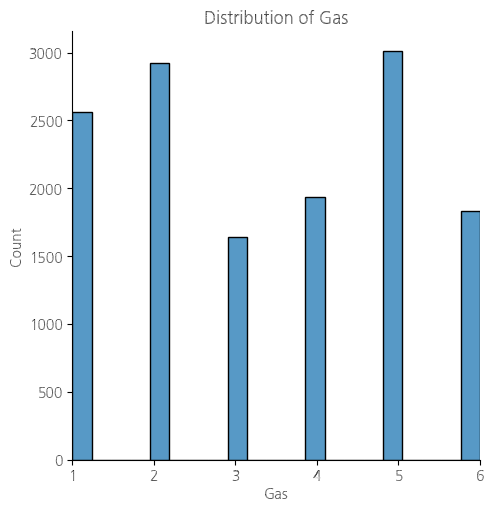

In [11]:
sns.displot(df.Gas)
plt.xlim(1, 6)
plt.title('Distribution of Gas')
plt.show()

#### 2) 농도가 다른 컬럼 확인


In [12]:
conc = df.iloc[:, 1]

<ipython-input-13-62690b664d8d>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(conc_red)


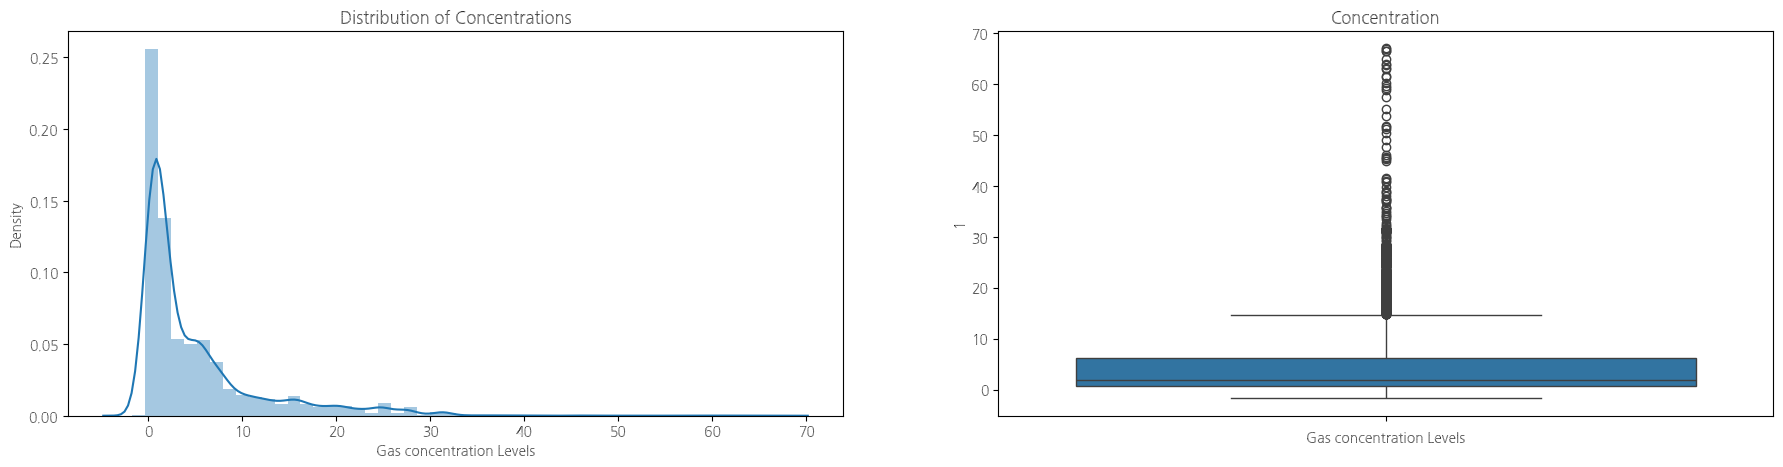

In [13]:
conc_red = conc.apply(lambda x: x/10000)

fig = plt.figure(figsize=(22, 5))
fig.add_subplot(121)
sns.distplot(conc_red)
plt.title("Distribution of Concentrations")
plt.xlabel("Gas concentration Levels")

fig.add_subplot(122)
sns.boxplot(conc_red)
plt.title("Concentration")
plt.xlabel("Gas concentration Levels")

plt.show()

#### 3) 데이터 확인

In [14]:
attr = df.iloc[:, 2:].copy()
attr.head()

,2,3,4,5,6,7,8,9,10,11,...,119,120,121,122,123,124,125,126,127,128
0,42.217819,8.077428,11.060225,15.324717,-6.237308,-8.640350,-22.773236,76987.3013,20.273385,22.973327,...,-18.088229,-30.107785,31626.1782,7.214432,14.421883,33.202304,40.598880,-8.920710,-15.434603,-28.125227
1,2.462359,0.790187,1.495105,3.545801,-0.402571,-0.806028,-3.984063,13496.0776,3.465433,4.987909,...,-2.466937,-5.849443,6707.0798,3.133532,4.428225,12.515252,16.296656,-1.397067,-2.223667,-4.842768
2,2.404817,0.803031,1.508790,3.572785,-0.397897,-0.753870,-3.771515,13525.2793,3.481527,5.011789,...,-2.429918,-6.307317,6697.3631,3.112266,4.443709,12.618117,16.957225,-1.399658,-2.184855,-5.350035
3,2.428299,0.788218,1.466609,3.962417,-0.381463,-0.779135,-4.069448,13500.1397,3.473563,5.194071,...,-2.444341,-5.607505,6637.2874,3.094251,4.620435,13.243091,17.279677,-1.368559,-2.113937,-5.843864
4,2.527231,0.842334,1.511417,3.055021,-0.431201,-0.808438,-3.819882,13428.2017,3.466001,4.983480,...,-2.352689,-5.552964,6695.1635,3.097356,4.433018,12.514647,16.905624,-1.368128,-2.234458,-5.394663


#### 4) 상관도 분석

/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


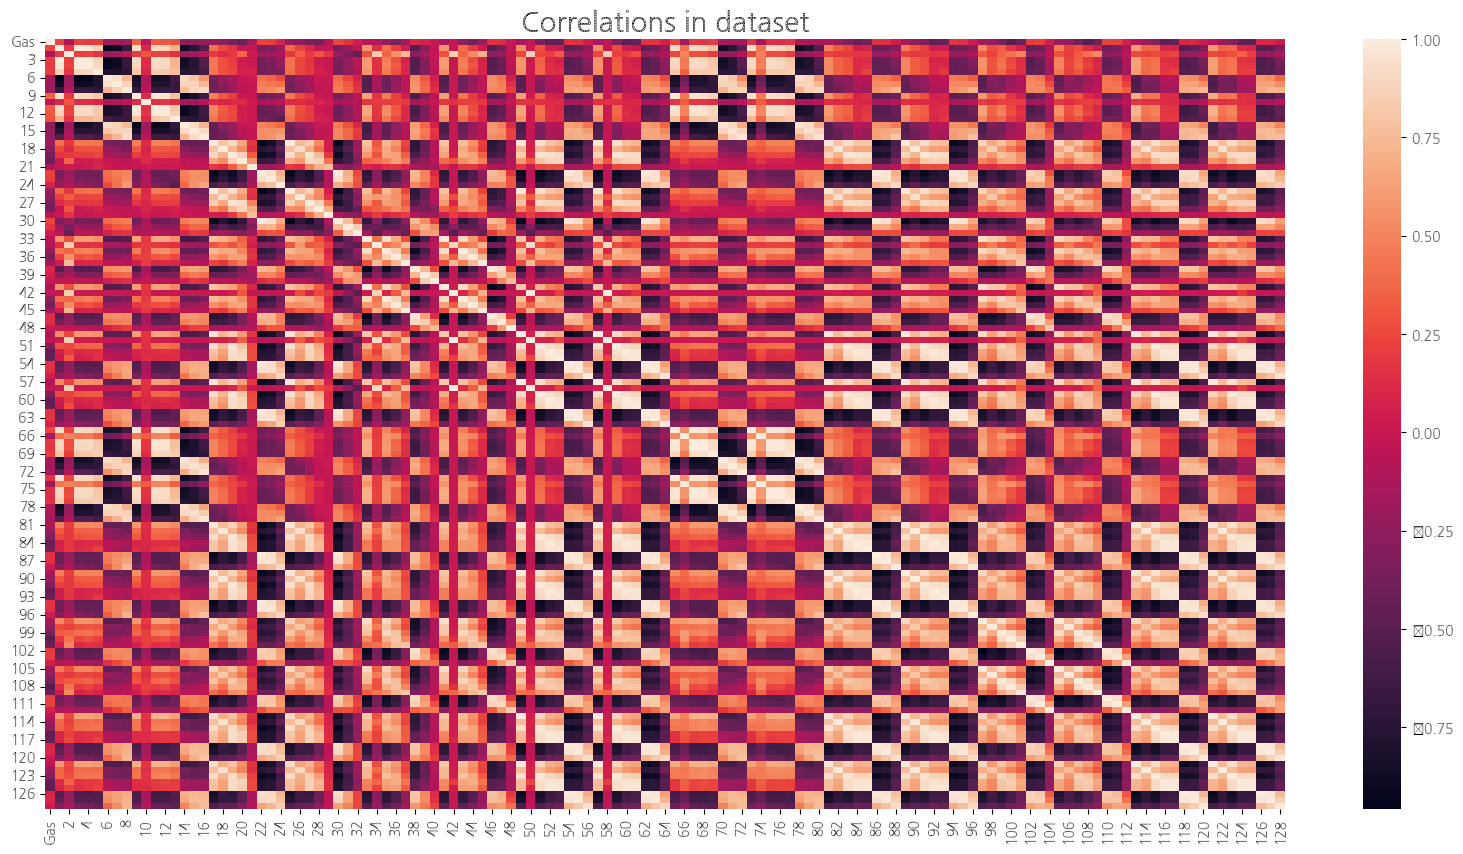

In [15]:
# 상관계수 계산
correlation = df.corr()

# Heatmap 그리기
f, ax = plt.subplots(figsize=(20, 10))
plt.title("Correlations in dataset", size=20)
sns.heatmap(correlation)
plt.show()

> 상관계수 상위 20개 (양수, 음수)

In [16]:
# 상관계수 정렬
conc_corr = correlation.iloc[:, 1].sort_values(ascending=False)

# 상위 20개 (양수)
conc_corr[1:].head(20)

3      0.983710
4      0.964275
73     0.931922
9      0.925908
65     0.918925
11     0.907179
75     0.907141
67     0.894082
76     0.883304
12     0.880074
68     0.870845
5      0.852414
77     0.808763
69     0.779136
13     0.694674
121    0.584990
113    0.583377
33     0.571334
41     0.565753
49     0.536699
Name: 1, dtype: float64

In [17]:
# 상위 20개 (음수)
conc_corr[1:].tail(20)

102   -0.462186
119   -0.467363
127   -0.473974
54    -0.474011
72    -0.497401
38    -0.500108
46    -0.501147
118   -0.514472
126   -0.520602
80    -0.538281
16    -0.544650
8     -0.677211
71    -0.752262
15    -0.755876
79    -0.801174
70    -0.862056
78    -0.874178
14    -0.878040
7     -0.882787
6     -0.951382
Name: 1, dtype: float64

#### 5) 상관도 기준 관계 그래프

In [18]:
fig = plt.figure(figsize=(20, 50))
for i in range(0, 20):
  fig.add_subplot(10, 2, i+1)
  sns.scatterplot(df, x=attr.iloc[:, conc_corr.index[i]], y=conc_red, hue="Gas", palette="Set1", legend="full")
  plt.xlabel(conc_corr.index[i])
  plt.ylabel("Gas Concentration")

fig.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

### 3. PCA 적용

#### 1) 데이터 준비

In [19]:
df_copy = df.copy()

X = df_copy.iloc[:, 1:]
y = df_copy.iloc[:, 0]

In [20]:
y.head()

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: Gas, dtype: float64

In [21]:
X.head()

,1,2,3,4,5,6,7,8,9,10,...,119,120,121,122,123,124,125,126,127,128
0,34181.6942,42.217819,8.077428,11.060225,15.324717,-6.237308,-8.640350,-22.773236,76987.3013,20.273385,...,-18.088229,-30.107785,31626.1782,7.214432,14.421883,33.202304,40.598880,-8.920710,-15.434603,-28.125227
1,3008.7476,2.462359,0.790187,1.495105,3.545801,-0.402571,-0.806028,-3.984063,13496.0776,3.465433,...,-2.466937,-5.849443,6707.0798,3.133532,4.428225,12.515252,16.296656,-1.397067,-2.223667,-4.842768
2,2872.7572,2.404817,0.803031,1.508790,3.572785,-0.397897,-0.753870,-3.771515,13525.2793,3.481527,...,-2.429918,-6.307317,6697.3631,3.112266,4.443709,12.618117,16.957225,-1.399658,-2.184855,-5.350035
3,2838.5399,2.428299,0.788218,1.466609,3.962417,-0.381463,-0.779135,-4.069448,13500.1397,3.473563,...,-2.444341,-5.607505,6637.2874,3.094251,4.620435,13.243091,17.279677,-1.368559,-2.113937,-5.843864
4,3099.6742,2.527231,0.842334,1.511417,3.055021,-0.431201,-0.808438,-3.819882,13428.2017,3.466001,...,-2.352689,-5.552964,6695.1635,3.097356,4.433018,12.514647,16.905624,-1.368128,-2.234458,-5.394663


#### 2) 테스트 모델 생성

In [22]:
pca = PCA(n_components=3)
X_train = pca.fit_transform(X)

#### 3) 그래프

##### 평면 그래프

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


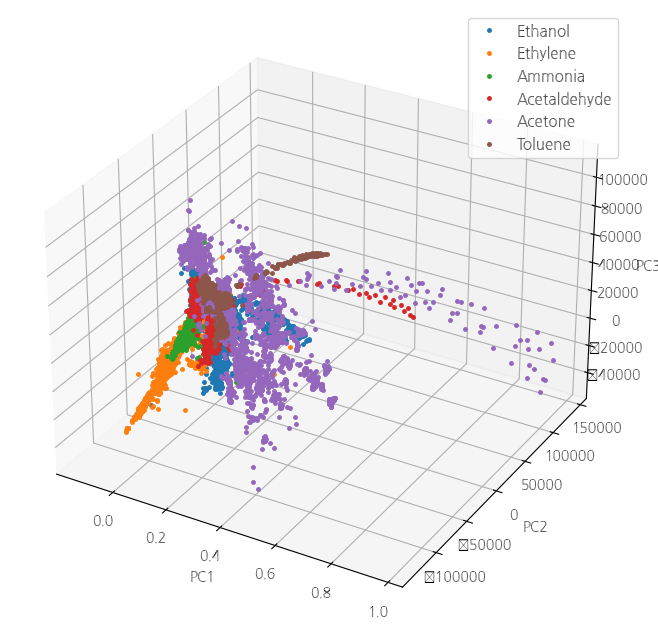

In [24]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.rcParams["legend.fontsize"] = 11
ax.plot(X_train[0:2564, 0], X_train[0:2564, 1], X_train[0:2564, 2], 'o', markersize=2.5, label='Ethanol')
ax.plot(X_train[2565:5490, 0], X_train[2565:5490, 1], X_train[2565:5490, 2], 'o', markersize=2.5, label='Ethylene')
ax.plot(X_train[5491:7131, 0], X_train[5491:7131, 1], X_train[5491:7131, 2], 'o', markersize=2.5, label='Ammonia')
ax.plot(X_train[7132:9067, 0], X_train[7132:9067, 1], X_train[7132:9067, 2], 'o', markersize=2.5, label='Acetaldehyde')
ax.plot(X_train[9068:12076, 0], X_train[9068:12076, 1], X_train[9068:12076, 2], 'o', markersize=2.5, label='Acetone')
ax.plot(X_train[12077:13909, 0], X_train[12077:13909, 1], X_train[12077:13909, 2], 'o', markersize=2.5, label='Toluene')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend(loc='upper right')

plt.show()

##### t-SNE 그래프

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


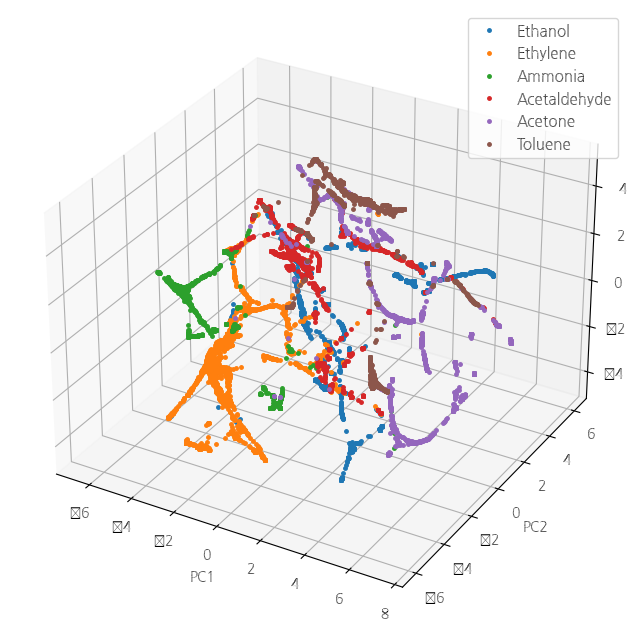

In [26]:
tsne = TSNE(n_components=3, n_iter=250)
xtrain = tsne.fit_transform(X)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.rcParams["legend.fontsize"] = 11
ax.plot(xtrain[0:2564, 0], xtrain[0:2564, 1], xtrain[0:2564, 2], 'o', markersize=2.5, label='Ethanol')
ax.plot(xtrain[2565:5490, 0], xtrain[2565:5490, 1], xtrain[2565:5490, 2], 'o', markersize=2.5, label='Ethylene')
ax.plot(xtrain[5491:7131, 0], xtrain[5491:7131, 1], xtrain[5491:7131, 2], 'o', markersize=2.5, label='Ammonia')
ax.plot(xtrain[7132:9067, 0], xtrain[7132:9067, 1], xtrain[7132:9067, 2], 'o', markersize=2.5, label='Acetaldehyde')
ax.plot(xtrain[9068:12076, 0], xtrain[9068:12076, 1], xtrain[9068:12076, 2], 'o', markersize=2.5, label='Acetone')
ax.plot(xtrain[12077:13909, 0], xtrain[12077:13909, 1], xtrain[12077:13909, 2], 'o', markersize=2.5, label='Toluene')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend(loc='upper right')

plt.show()

#### 4) Scaling

In [27]:
X_scaled = X.copy()
X_scaled = StandardScaler().fit(X_scaled).transform(X_scaled)

#### 5) PCA Step 1 - Covariance Matrix 만들기

In [28]:
cov_matrix = np.cov(X_scaled.T)

#### 6) PCA Step2 - Eigen Values 와 Eigen Vector 만들기

In [30]:
eig_val, eig_vec = np.linalg.eig(cov_matrix)

print("Eigenvectors \n%s" %eig_vec)
print("\nEigenvalues \n%s" %eig_val)

Eigenvectors 
[[-0.0645562  -0.16074832  0.07673187 ... -0.00176562  0.00224816
  -0.0013844 ]
 [-0.03928322  0.0131181   0.25758087 ...  0.00051409  0.00485384
   0.00466299]
 [-0.06963195 -0.15302955  0.08311936 ...  0.01337963  0.00379264
  -0.01315294]
 ...
 [ 0.11390782  0.02311344  0.04943856 ... -0.03447063 -0.16008231
  -0.37390377]
 [ 0.11165071  0.0255479   0.08134247 ... -0.01021104  0.04949433
   0.06876995]
 [ 0.08574406  0.03615492  0.14675375 ... -0.00109976  0.00128002
   0.00310437]]

Eigenvalues 
[6.85042981e+01 1.92526590e+01 7.73912358e+00 6.50925577e+00
 4.51574701e+00 3.71997843e+00 2.98686088e+00 2.00916826e+00
 1.85511435e+00 1.49931765e+00 1.31375992e+00 1.14936406e+00
 9.00292272e-01 7.89745838e-01 6.85881726e-01 5.78044819e-01
 4.74517874e-01 3.65584238e-01 3.45677293e-01 3.16136647e-01
 2.63945383e-01 2.31781051e-01 2.12481812e-01 1.79795875e-01
 1.54232070e-01 1.48625600e-01 1.19601193e-01 1.01662791e-01
 9.66988484e-02 7.22834259e-02 6.47650714e-02 5.78556

In [31]:
tot = sum(eig_val)
var_exp = [( i/tot ) * 100 for i in sorted(eig_val, reverse=True)]

cum_var_exp = np.cumsum(var_exp)

print('누적 분산 설명력', cum_var_exp)

누적 분산 설명력 [ 53.51513539  68.55519394  74.60094957  79.68594005  83.21361378
  86.11963799  88.45295529  90.02250515  91.47170905  92.64296675
  93.6692679   94.56714402  95.2704468   95.88739138  96.42319795
  96.874763    97.24545344  97.53104559  97.80108656  98.04805056
  98.25424307  98.435309    98.60129848  98.74175391  98.86223905
  98.97834445  99.07177617  99.15119451  99.22673506  99.28320242
  99.3337965   99.37899299  99.4219317   99.45953852  99.49590818
  99.53087312  99.563476    99.59494978  99.62255888  99.64784141
  99.67046802  99.69177561  99.7103468   99.72756841  99.74431185
  99.76041583  99.77621149  99.79159572  99.80487506  99.81740006
  99.82946985  99.84073248  99.85129979  99.86090798  99.86962065
  99.87787534  99.88571422  99.89264164  99.89932576  99.90537033
  99.91127457  99.91664737  99.92162254  99.92654255  99.93112871
  99.93530431  99.93937299  99.94334187  99.94707578  99.9505909
  99.95391235  99.95706009  99.96002937  99.96286255  99.96552932
 

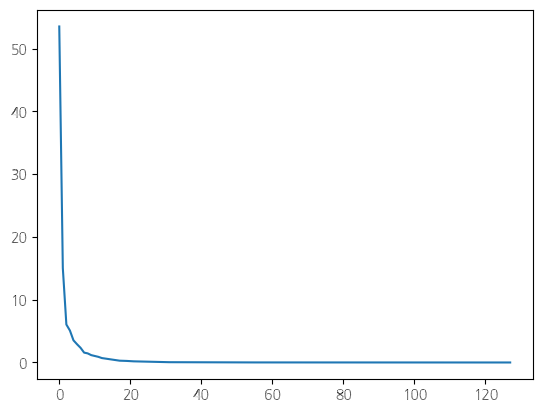

In [32]:
plt.plot(var_exp)

<ipython-input-33-03c8b8ed63d9>:7: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


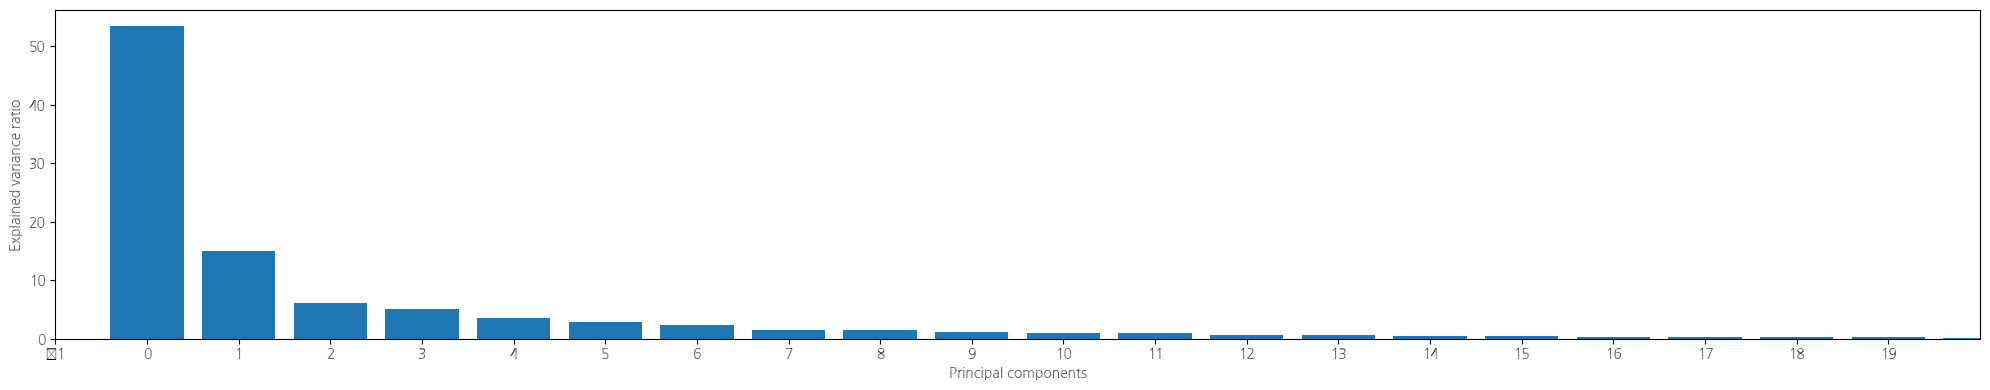

In [33]:
plt.figure(figsize=(20, 4))
plt.bar(range(128), var_exp)
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.xlim(0, 20)
plt.xticks(range(-1, 20))
plt.tight_layout()

#### 7) Scikit-learn으로 PCA 적용하기

In [34]:
pca = PCA()
X_scaled = pca.fit_transform(X_scaled)

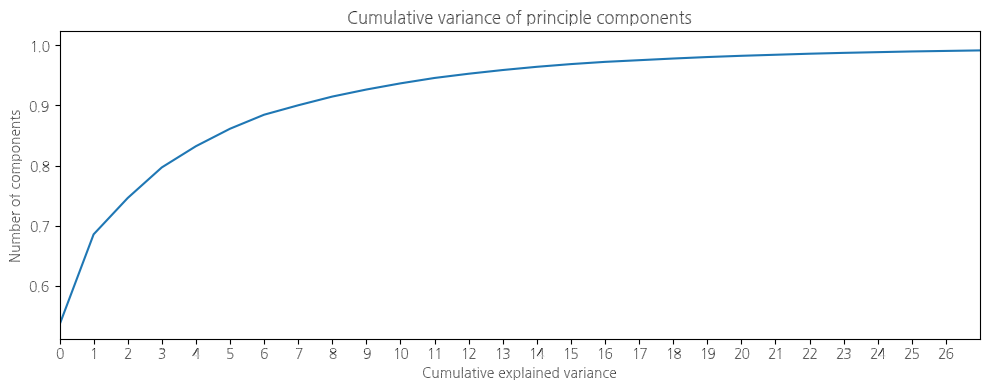

In [36]:
plt.figure(figsize=(10, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0, 27)
plt.xticks(range(0, 27))
plt.title("Cumulative variance of principle components")
plt.ylabel('Number of components')
plt.xlabel('Cumulative explained variance')
plt.tight_layout()

In [37]:
print(pca.explained_variance_ratio_)

[5.35151354e-01 1.50400585e-01 6.04575563e-02 5.08499048e-02
 3.52767372e-02 2.90602421e-02 2.33331730e-02 1.56954986e-02
 1.44920390e-02 1.17125771e-02 1.02630115e-02 8.97876122e-03
 7.03302773e-03 6.16944581e-03 5.35806576e-03 4.51565049e-03
 3.70690438e-03 2.85592153e-03 2.70040970e-03 2.46964000e-03
 2.06192506e-03 1.81065928e-03 1.65989482e-03 1.40455429e-03
 1.20485142e-03 1.16105403e-03 9.34317149e-04 7.94183453e-04
 7.55405442e-04 5.64673667e-04 5.05940745e-04 4.51964933e-04
 4.29387084e-04 3.76068232e-04 3.63696523e-04 3.49649402e-04
 3.26028840e-04 3.14737802e-04 2.76090995e-04 2.52825321e-04
 2.26266069e-04 2.13075933e-04 1.85711913e-04 1.72216049e-04
 1.67434435e-04 1.61039791e-04 1.57956606e-04 1.53842337e-04
 1.32793336e-04 1.25249975e-04 1.20697976e-04 1.12626251e-04
 1.05673149e-04 9.60818774e-05 8.71266938e-05 8.25468534e-05
 7.83888702e-05 6.92742002e-05 6.68411576e-05 6.04457647e-05
 5.90423887e-05 5.37279875e-05 4.97516644e-05 4.92001569e-05
 4.58615714e-05 4.175597